# Uncertain predictions
It can be very useful to generate prediction on how certain the model is about a given prediction. In this work, we take two approaches to doing so. The first is by using a Gaussian Process, which directly predicts uncertainty. Unfortunately, this only work on regression tasks. The second is by using ensambles of generic models. The model is fit on a subset of the data and then the disagreement between the predictions provides a notion of uncertainty. This technique is flexible because any prediction system can be ensambled, for both classification and regression tasks.

In [1]:
import torch
from ipp_toolkit.predictors.masked_image_predictor import (
    EnsambledMaskedLabeledImagePredictor,
    UncertainMaskedLabeledImagePredictor,
)
from ipp_toolkit.predictors.pytorch_predictor import PytorchPredictor, MLPNetwork
from ipp_toolkit.planners.masked_planner import RandomSamplingMaskedPlanner
from ipp_toolkit.predictors.uncertain_predictors import GaussianProcessRegression
from ipp_toolkit.data.domain_data import ALL_LABELED_DOMAIN_DATASETS
from ipp_toolkit.visualization.visualization import visualize_prediction

device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/david/anaconda3/envs/ipp-toolkit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Gaussian Process regression
Here we apply Gaussian Process regression to the datasets which have a regression task.

Running cuprite_aviris dataset
Running cuprite_aster dataset
Running cuprite_aster_aviris dataset
Running aiira dataset
Everything is up to date.


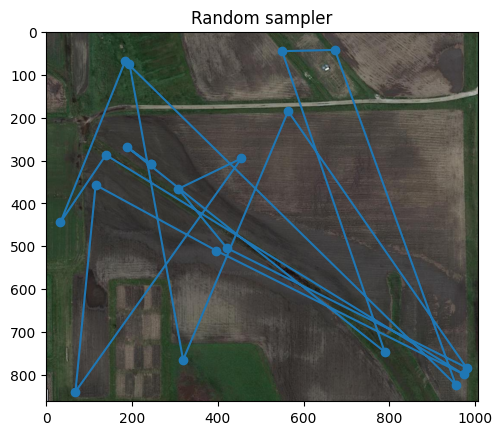

Error is 17.433704059875538


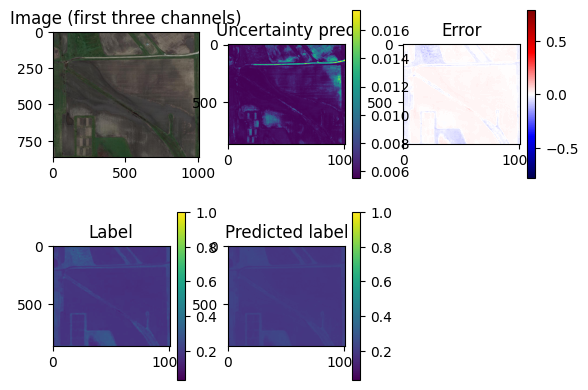

Running safeforest_gmap dataset


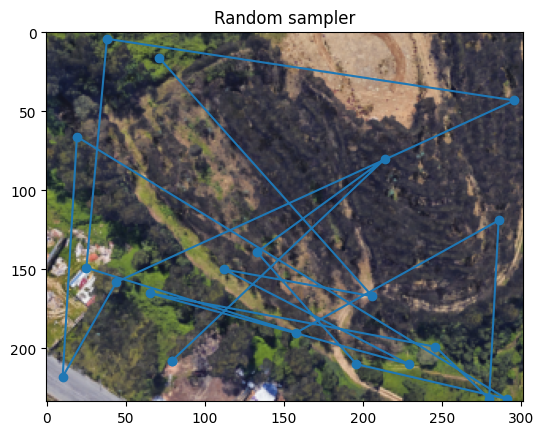

Error is 4.724593984120874


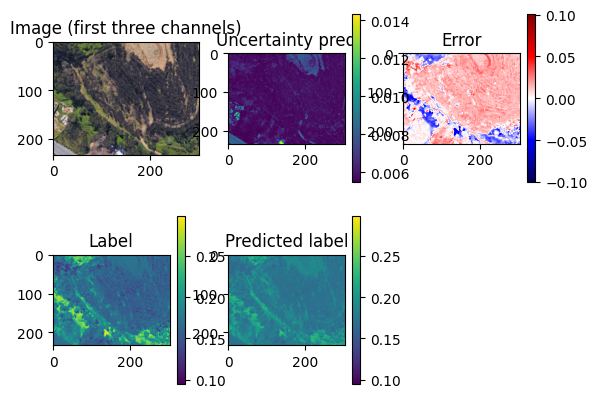

Running safeforest_ortho dataset


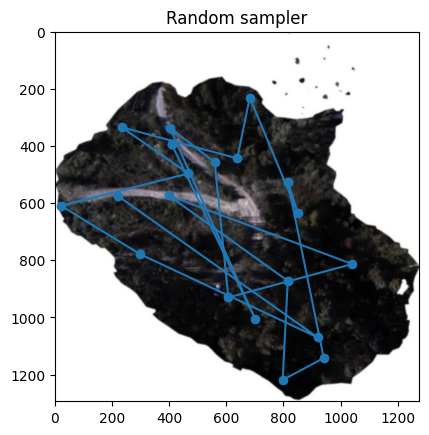

Error is 15.358070476730123


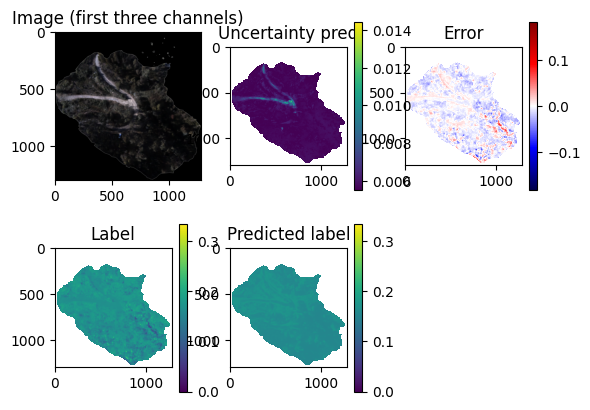

Running yellowcat dataset


/home/david/anaconda3/envs/ipp-toolkit/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The yellowcat dataset is a classification task, which is not supported
Running chesapeake dataset
Running reforestree dataset
Running coral dataset


In [2]:
# The number of training samples to observe
N_SAMPLES = 20
for name, dataset_class in ALL_LABELED_DOMAIN_DATASETS.items():
    print(f"Running {name} dataset")
    try:
        # Create the data manager
        data = dataset_class()
    except (RuntimeError, FileNotFoundError):
        continue
    # The gaussian process regressor does not support classification
    if data.is_classification_dataset():
        print(f"The {name} dataset is a classification task, which is not supported")
        continue
    # Define a gaussian process regression model
    # It will adapt to the number of features at runtim
    gaussian_process = GaussianProcessRegression(device=device)
    # Create a planner based on the data
    planner = RandomSamplingMaskedPlanner(data)
    # Create a predictor to generate predictions on this dataset
    predictor = UncertainMaskedLabeledImagePredictor(
        data, uncertain_prediction_model=gaussian_process, classification_task=False
    )
    # Get a random plan
    plan = planner.plan(20, vis=True)
    # Sample values from the environment
    values = data.sample_batch(plan)
    # Fit the model
    predictor.update_model(plan, values)
    # Generate predictions for both the label and the label unceratainty
    prediction = predictor.predict_values_and_uncertainty()
    # Visualize these predictions alongside the ground truth
    visualize_prediction(data, prediction)


### Ensambling
Here we use an ensamble of multilayer perceptron regressors or classifiers. This is tested on a variety of datasets.

Running cuprite_aviris dataset
Running cuprite_aster dataset
Running cuprite_aster_aviris dataset
Running aiira dataset
Everything is up to date.


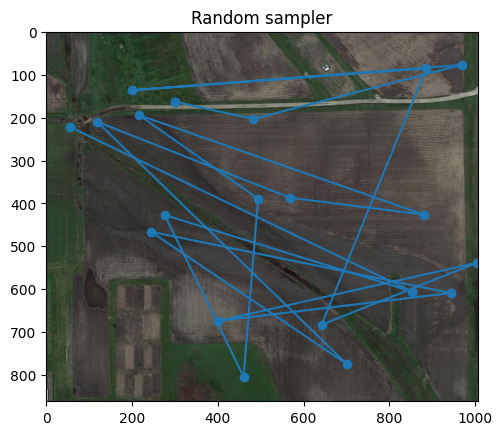

Error is 47.42630203544585


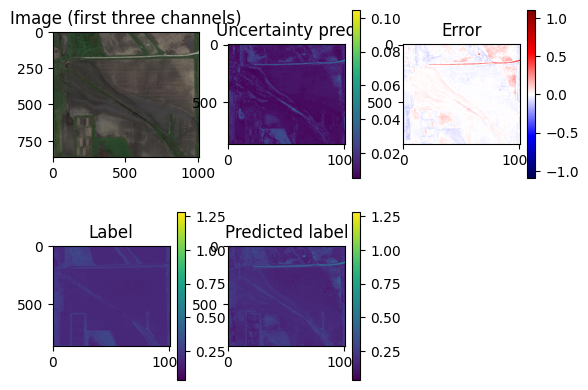

Running safeforest_gmap dataset


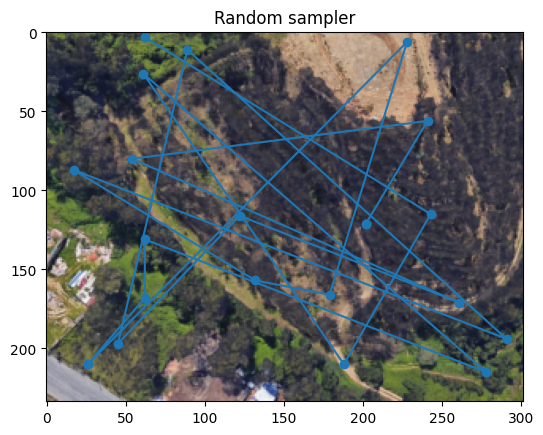

Error is 6.504250140517549


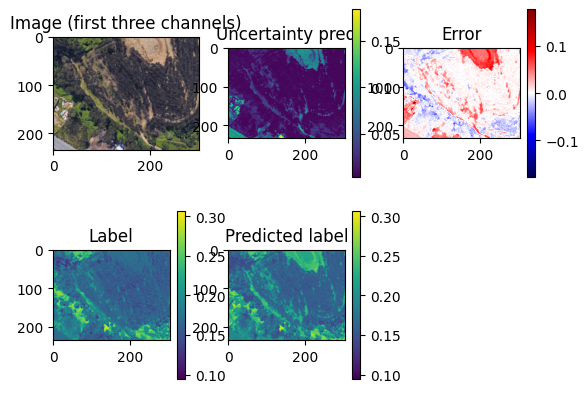

Running safeforest_ortho dataset


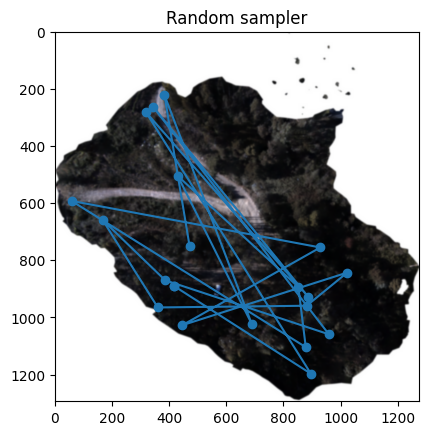

Error is 30.37577206497501


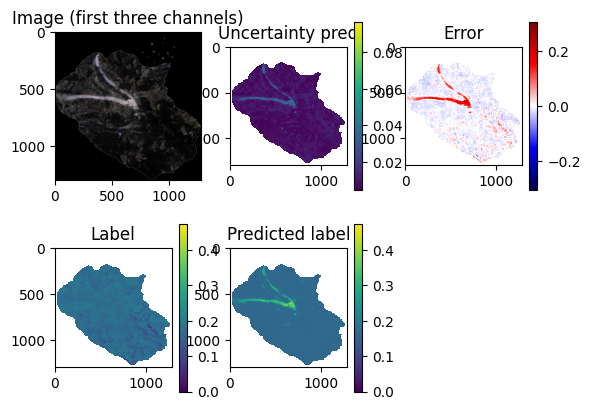

Running yellowcat dataset


/home/david/anaconda3/envs/ipp-toolkit/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


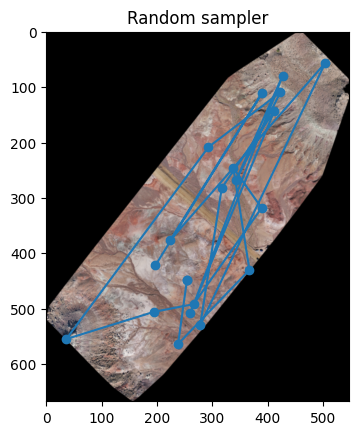

Error is 0.25161262284802544


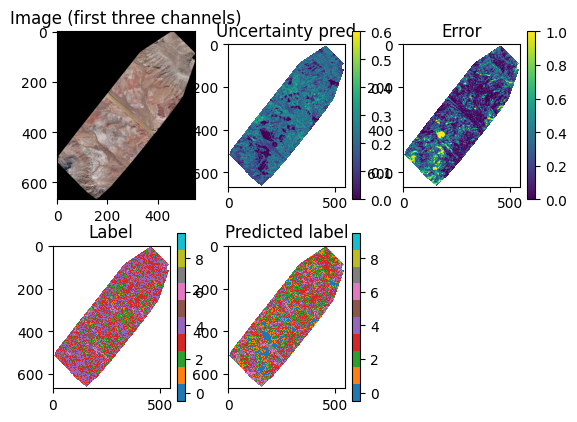

Running chesapeake dataset
Running reforestree dataset
Running coral dataset


In [3]:
# The number of training samples to observe
N_SAMPLES = 20
for name, dataset_class in ALL_LABELED_DOMAIN_DATASETS.items():
    print(f"Running {name} dataset")
    # Create the data manager
    try:
        # Create the data manager
        data = dataset_class()
    except (RuntimeError, FileNotFoundError):
        continue
    # Define a prediction model based on the type of task
    input_dim = data.image.shape[-1]
    output_dim = data.n_classes if data.is_classification_dataset() else 1
    model = PytorchPredictor(
        model=MLPNetwork(input_dim=input_dim, output_dim=output_dim),
        classification_task=data.is_classification_dataset(),
        criterion=torch.nn.CrossEntropyLoss()
        if data.is_classification_dataset()
        else torch.nn.MSELoss(),
        device=device,
    )
    # Create a planner based on the data
    planner = RandomSamplingMaskedPlanner(data)
    # Create a predictor to generate predictions on this dataset
    predictor = EnsambledMaskedLabeledImagePredictor(
        data,
        prediction_model=model,
        n_ensamble_models=10,
        classification_task=data.is_classification_dataset(),
    )
    # Get a random plan
    plan = planner.plan(20, vis=True)
    # Sample values from the environment
    values = data.sample_batch(plan)
    # Fit the model
    predictor.update_model(plan, values)
    # Generate predictions for both the label and the label unceratainty
    prediction = predictor.predict_values_and_uncertainty()
    # Visualize these predictions alongside the ground truth
    visualize_prediction(data, prediction)
